# test model on test data 
Test the model on the test data and save the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
from utils.plots import plot_label_distribution_datasets
from utils.helpers_config import set_up_config, save_config, print_config
from utils.test.helpers_testing import get_test_stats_from_model, load_test_dataset, save_test_stats
from utils.plots_test import plots_all_figs_at_test, plot_confusion_matrix_like_elects
import matplotlib.pyplot as plt
from utils.test.load_model import get_all_runs, get_loaded_model_and_criterion, get_model_and_model_path
from utils.helpers_mu import get_mus_from_config
from utils.results_analysis.extract_video import download_images, add_files_to_images, save_video
import argparse

In [3]:
run_name = "v1"
sequencelength_test = None
plot_label_distribution = False
print("Run name: ", run_name)


Run name:  v1


In [4]:
print(f"Test the model from run '{run_name}' on the test dataset")
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
print("Local dataroot: ", local_dataroot)

# ## Download the model from wandb 
entity, project = "aurenore", "MasterThesis"
runs_df, runs = get_all_runs(entity, project)

# get the run with name:
run_idx = runs_df[runs_df.name == run_name].index[0]
run = runs[run_idx]
run_config = argparse.Namespace(**run.config)
model_artifact, model_path = get_model_and_model_path(run)

# get and save the config
config_path = save_config(model_path, run)
print_config(run)
args  = set_up_config(run_config)
args.dataroot = local_dataroot

# ----------------------------- LOAD DATASET -----------------------------
# Set the sequence length to 150 like in the original paper.
if sequencelength_test is None: 
    sequencelength_test = run_config.sequencelength
else: 
    args.sequencelength = sequencelength_test
test_ds, nclasses, class_names, input_dim = load_test_dataset(args)

# ----------------------------- VISUALIZATION: label distribution -----------------------------
if plot_label_distribution:
    datasets = [test_ds]
    sets_labels = ["Test"]
    fig, ax = plt.subplots(figsize=(15, 7))
    fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

# ## Load the models and the criterions
mus = get_mus_from_config(args)
model, criterion = get_loaded_model_and_criterion(run, nclasses, input_dim, mus=mus)

# ## Test the model on the test dataset
test_stats, stats = get_test_stats_from_model(model, test_ds, criterion, args)
print("test_stats:\n", test_stats)
test_stats_path = save_test_stats(model_path, test_stats)


Test the model from run 'v1' on the test dataset
Local dataroot:  C:\Users\anyam\elects_data


wandb:   1 of 1 files downloaded.  


config file saved at:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-5dazxzo8-model.pth-v27\config.json
-------------------------------------------------- Configuration: --------------------------------------------------
mu: 150
mus: [122, 72, 102, 103, 150, 150, 150]
loss: daily_reward_piecewise_lin_regr
alpha: 1
device: cuda
epochs: 100
factor: v1
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.7
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 128
corrected: True
alpha_decay: [1, 0.4]
hidden_dims: 128
loss_weight: balanced
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
decision_head: day
learning_rate: 0.001
nb_parameters: 264994
sequencelength: 365
validation_set: valid
daily_timestamps: True
day_head_init_bias: 1
percentage_alpha_1: 0.

loading data into RAM: 100%|██████████| 2463/2463 [00:01<00:00, 1777.25it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 36915/36915 [00:17<00:00, 2150.87it/s]


class names: ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']


wandb:   1 of 1 files downloaded.  
c:\Users\anyam\Desktop\Master_thesis\Code\elects\utils\test\load_model.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(run_config.class_weights)


loss daily_reward_piecewise_lin_regr selected, mus set to tensor([122,  72, 102, 103, 150, 150, 150])
model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-5dazxzo8-model.pth-v27
The model has 264,994 trainable parameters.
weights moved to device cuda
test_stats:
 {'test_loss': 5.4705067, 'accuracy': 0.7415054091116867, 'precision': 0.6383262608300446, 'recall': 0.694935747157346, 'fscore': 0.6570391067022199, 'kappa': 0.6681470711419871, 'elects_earliness': 0.6046755063210951, 'classification_loss': 13.441761, 'earliness_reward': 2.4429545, 'harmonic_mean': 0.6661365549819788, 'std_score': 27.424230811484176}
test_stats saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-5dazxzo8-model.pth-v27\test_stats.json


# --------------------- VISUALIZATION: stopping times and timestamps left-----------------------------


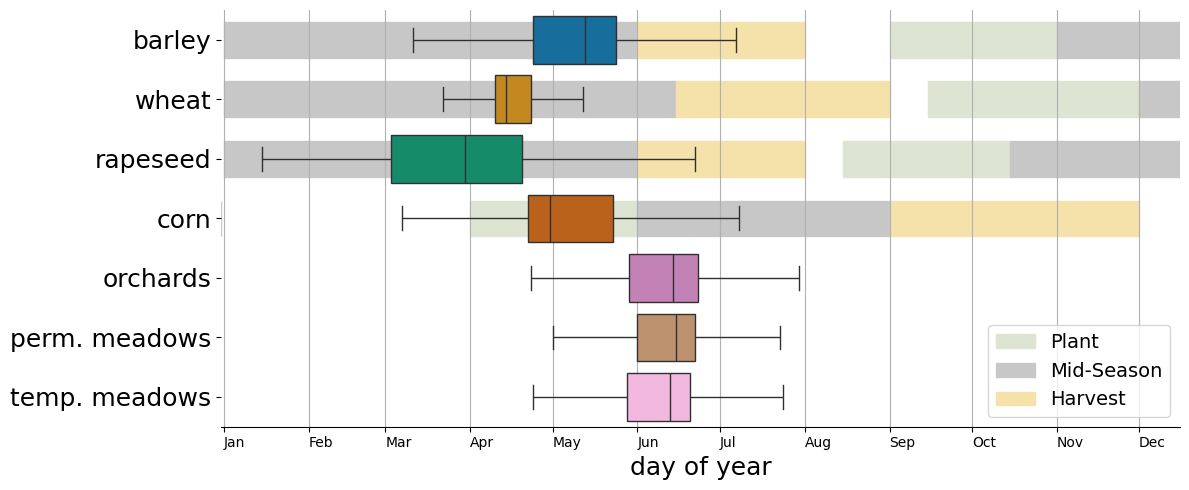

In [5]:
from utils.plots import boxplot_stopping_times, plot_timestamps_left_per_class, create_figure_and_axes
from utils.doy import get_doys_dict_test, get_doy_stop

fig_boxplot, ax_boxplot = plt.subplots(figsize=(12, 5))
if args.daily_timestamps:
    doys_stop = stats["t_stop"].squeeze()
else: 
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, ax_boxplot = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names, show_crop_calendar=True)
# fig_filename = os.path.join(model_path, "boxplot_stopping_times.png")
# fig_boxplot.savefig(fig_filename)
# print("fig saved at ", fig_filename)


final_labels_names ['barley', 'wrong barley', 'wheat', 'wrong wheat', 'rapeseed', 'wrong rapeseed', 'corn', 'wrong corn', 'orchards', 'wrong orchards', 'perm. meadows', 'wrong perm. meadows', 'temp. meadows', 'wrong temp. meadows']


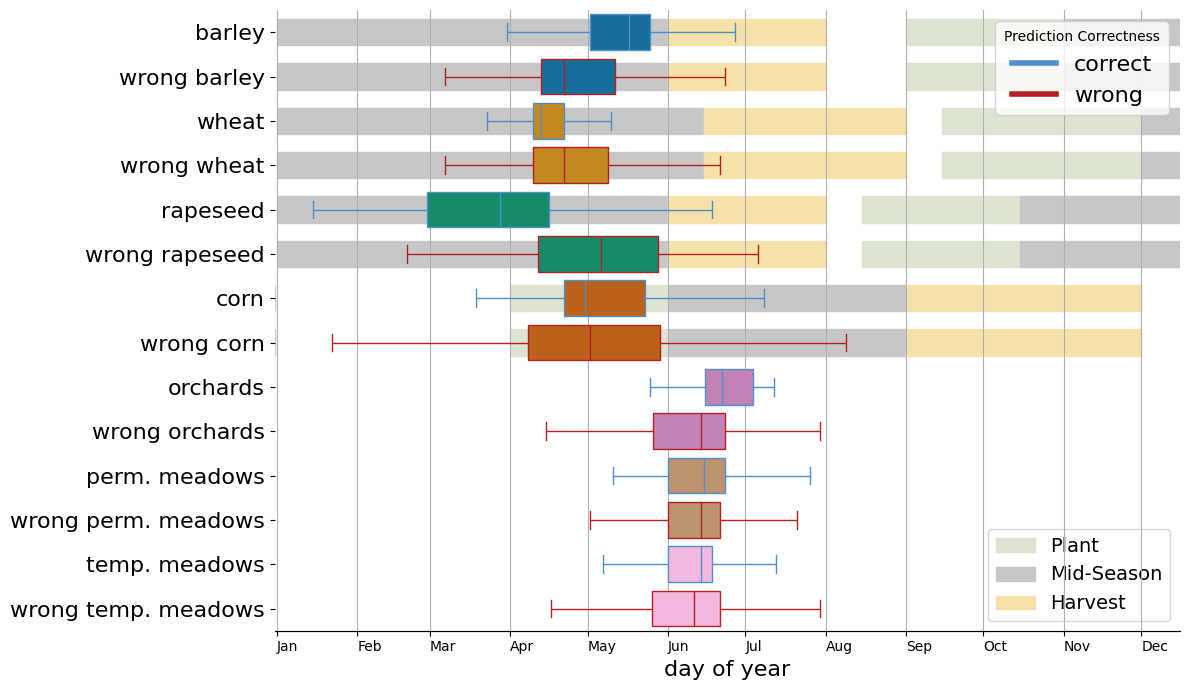

In [16]:
from utils.plots_test import boxplot_stopping_times_and_correctness
fig_boxplot_correctness, ax_boxplot_correctness = plt.subplots(figsize=(12, 7))
fig_boxplot_correctness, _ = boxplot_stopping_times_and_correctness(doys_stop, stats, fig_boxplot_correctness, ax_boxplot_correctness, class_names, show_crop_calendar=True)

AssertionError: 

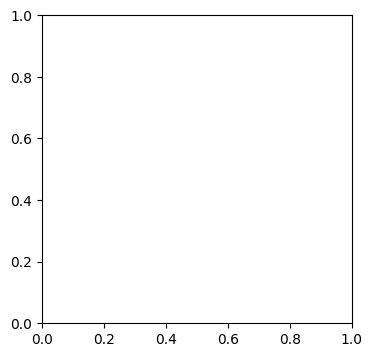

In [7]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
fig, ax = plot_confusion_matrix_like_elects(fig, ax, stats)